# Indian Portfolio Analysis
"Those who do not remember the past are condemned to repeat it."-George Santayana

This is ongoing work, which is built on the premise that people in financial markets act have a very high affinity to believe that the past should influence the future. The goal of this script is to provide a long term investor a unified view on the equity markets by providing a simple way to explore past performances of a variety of assets. This includes sampling asset returns within a window to construct a distribution of expected returns, estimating correlations in performance of assets, identifying high beta, and high sharpe ratio assets.The script also leverages the YFinance API to provide a unified look into the balance sheet, cash flow statement, industry and sector of a given asset to allow for macro-analysis.
Subsequently, the goal is to include functionalities to run diagnostics on the existing portfolio and subject it to certain effects to observe what might be the expected performance.


In [ ]:
!pip install yfinance
!pip install yahoofinancials
!pip install plotly==4.14.3
!pip install pacmap
from IPython.display import clear_output
clear_output()
import gdown

In [ ]:
import pandas as pd
import numpy as np
import datetime
import os
# import pacmap
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import random
import math
import statistics
from yahoofinancials import YahooFinancials
import yfinance as yf
import seaborn as sns
import json
import plotly.graph_objects as go
import plotly.express as px
from abc import ABC, abstractmethod
url = "https://drive.google.com/drive/folders/1w_H48jgbH3Z0wdZ-vUziFzTmH2RO-K8f?usp=sharing"
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

gdown.download_folder(url)

Retrieving folder contents


Processing file 16G95D3LikTD_bomQyBxKAU3-moOmwtjR all_scripts.xlsx


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=16G95D3LikTD_bomQyBxKAU3-moOmwtjR
To: /content/SharesData/all_scripts.xlsx
100%|██████████| 137k/137k [00:00<00:00, 54.7MB/s]
Download completed


['/content/SharesData/all_scripts.xlsx']

# DEFINE ECONOMIC CONSTANTS
We first define some economic constants that will help us to compute returns. These economic constants are important from a macroeconomic perspective of how they affect the business environment by affecting  cash liquidity and the cost of borrowing capital.

In [ ]:


# Assume the risk free rate as the 1 year FD interest https://www.hdfcbank.com/personal/save/deposits/fixed-deposit-interest-rate
RISK_FREE_BASE_RATE= 0.066 # have to make this dynamic based on the rates from FRED?

# Define a start and end date for the economic period being studied
START_DATE="2021-01-01"

now = datetime.datetime.now()
if now.weekday() >= 5:
    last_working_day = now - datetime.timedelta(days=now.weekday() - 4)
else:
    last_working_day = now

END_DATE = last_working_day.strftime("%Y-%m-%d")

# Define the tax rates on short and long term capital gains
LONG_TERM_CAP_GAINS=0.125
SHORT_TERM_CAP_GAINS=0.20

# Define the duration of the long term investment
LONG_TERM_DURATION=datetime.timedelta(days=365)


# Define the number of trading days in a year
TRADING_DAYS=252
DAYS_PER_YEAR=365

# Define initial cash and carry forward loss position
CASH=0
CARRY_FORWARD_LOSS=0


In [ ]:
def parseupload(file):
  """
  Parses uploaded file to identify stock ticker names.
  Taken from https://www.nseindia.com/regulations/listing-compliance/nse-market-capitalisation-all-companies

  Args: takes a filename and requires file upload

  Returns: list of ticker names

  """
  all_scripts=pd.read_excel(file)
  tickers =[]
  for symbol in all_scripts['Symbol']:
    try:
      tickers.append(symbol+".NS")
    except:
      pass
  return tickers[:-1]

NSE_all_scripts=parseupload(file='SharesData/all_scripts.xlsx')


In [ ]:
class Asset:
    def __init__(self, start_date, name, category ):
      self.name=name
      self.start_date=start_date
      self.category=category

    @abstractmethod
    def get_quotes(self):
      pass
    @abstractmethod
    def sample_returns(self):
      pass
    @abstractmethod
    def get_details(self):
      pass
    @abstractmethod
    def __str__(self):
      pass
    @abstractmethod
    def __repr__(self):
      pass

    @abstractmethod
    def time_stamps(self):
      pass

class Cash(Asset):
    def __init__(self, val, start_date=START_DATE, end_date=END_DATE):
        self.val = val

    def add_cash(self, cash):
        self.cash += cash

    def assert_sufficient_cash(self, withdrawal):
        return self.cash >= withdrawal

    def remove_cash(self, withdrawal):
        if self.assert_sufficient_cash(withdrawal):
            self.cash -= withdrawal
        else:
            print("Insufficient funds")

class Bouquet(Asset):
  """
  A bouquet is a collection of stocks. It allows us to combine two or more stocks in some definite proportion to see how returns change.
  """
  def __init__(self, stocks, allocation):
    assert(sum(allocation)==1)

class Stock(Asset):
    def __init__(self, name, start_date=START_DATE, end_date=END_DATE):
        self.ticker = yf.Ticker(name)
        self.name = name
        self.info = self.ticker.info
        self.start_date = start_date
        self.end_date = end_date

        self.income_stmt = self.ticker.income_stmt
        self.quarterly_income_stmt = self.ticker.quarterly_income_stmt
        self.balance_sheet = self.ticker.balance_sheet
        self.quarterly_balance_sheet = self.ticker.quarterly_balance_sheet
        self.cashflow = self.ticker.cashflow
        self.quarterly_cashflow = self.ticker.quarterly_cashflow
        # Safely accessing dictionary keys with default values
        self.sector = self.info.get('sector', 'Unknown')
        self.industry = self.info.get('industry', 'Unknown')
        self.regularMarketVolume = self.info.get('regularMarketVolume', 0)
        self.marketCap = self.info.get('marketCap', 0)
        self.beta = self.info.get('beta', 1)
        self.get_quotes()

    def get_quotes(self,):
        df_quotes=pd.DataFrame
        df_quotes = yf.download(self.name,
                        start =self.start_date,
                        end = self.end_date, actions=True)
        self.values=df_quotes
        self.adj_close=df_quotes[['Adj Close']]
        self.volume=df_quotes['Volume']
        self.smoothed_volume=self.compute_sma(window=30,column='Volume')
        self.sma30=self.compute_sma(window=30,column='Adj Close')
        self.sampled_returns_mean,self.sampled_returns_var,self.sampled_returns=self.sampled_returns() # mean return, variance in returns, distribution
        self.max_drawdown=self.compute_treynor_ratio()
        self.sharpe=self.compute_sharpe_ratio()
        self.treynor=self.compute_treynor_ratio()
        self.normalized_adj_close=self.normalize(df_quotes['Adj Close'])

    # def get_tail_risk(self,):
    #   '''
    #   Returns the greatest observed meltdown as well as the dates of that meltdown to allow for diagnosis into what might have cause such movement.
    #   '''
    #     self.adj_close

    def sampled_returns(self, n_samples=5000, trading_days=252, years=1, error=5, alpha=1, beta=1, eps=3):
        sample_returns = []
        for i in range(n_samples):
            s_date = min(math.floor(random.betavariate(alpha, beta) * len(self.values)), len(self.values) - trading_days * years)
            e_date = min(math.floor(s_date + trading_days * years + random.random() * eps - eps), len(self.values) - 1)
            if s_date < len(self.values) and e_date < len(self.values):
                i_return = (self.values['Adj Close'].iloc[e_date] - self.values['Adj Close'].iloc[s_date]) / self.values['Adj Close'].iloc[s_date]
                sample_returns.append(i_return)
        return np.mean(sample_returns), np.var(sample_returns), sample_returns

    def compute_max_draw_down(self):
        df = self.values['Adj Close']
        roll_max = df.cummax()
        daily_drawdown = df / roll_max - 1.0
        max_drawdown = daily_drawdown.cummin().min()
        return max_drawdown

    def compute_sharpe_ratio(self, risk_free_rate=RISK_FREE_BASE_RATE):
        returns = self.values['Adj Close'].pct_change().dropna()
        excess_returns = returns - risk_free_rate / TRADING_DAYS
        sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(TRADING_DAYS)
        return sharpe_ratio

    def compute_treynor_ratio(self, risk_free_rate=RISK_FREE_BASE_RATE):
        returns = self.values['Adj Close'].pct_change().dropna()
        excess_returns = returns - risk_free_rate / TRADING_DAYS
        beta = self.beta
        treynor_ratio = np.mean(excess_returns) / beta
        return treynor_ratio

    def compute_sma(self, window, column):
        self.values['SMA'] = self.values[column].rolling(window=window).mean()
        return self.values['SMA']

    def __str__(self):
        return f"Ticker: {self.name}"

    def __repr__(self):
        return self.__str__()
    def normalize(self,data):
      min_val = data.min()
      max_val = data.max()
      normalized_data = (data - min_val) / (max_val - min_val)
      return normalized_data





In [ ]:
class Portfolio:
    """
    A portfolio of assets. We also store portfolio information to display by sector to show industry exposure.
    """

    def __init__(self, portfolio_name,  trade_log_file=None, asset_list=None, mode='list', map_directors=False):
        """
        We can construct a portfolio in two ways: one is to simply upload a summary of current holdings as a list.
        The other is to upload a trade log file with all past trades from which we will construct a summary of current holdings.
        """
        if (mode=='tradefile'):
          self.trade_log_file = pd.read_excel(trade_log_file) # read all the trades.
          asset_list=self.trade_log_file['Name']
        else:
          self.asset_list=asset_list

        self.size=len(self.asset_list)
        self.assets = dict() #dictionary of name to its ticker object
        for i,symbol in enumerate(asset_list):
            print(symbol)
            if symbol[0]!="*":
                if (symbol not in self.assets.keys()):
                  try:
                    self.assets[symbol]=(Stock(symbol )) # construct a dictionary with the stock objects mapped to the string of the ticker.
                  except:
                      print("Unable to find",symbol)
            elif symbol[0]=="*":
              self.assets[symbol]=Cash(symbol,val=self.trade_log_file.iloc[i]['Units'])

        self.name = portfolio_name
        self.sectoral_dict=self.map_to_sector()
        self.director_to_company=dict()
        if map_directors:
          self.map_to_directors()
        if (mode=='tradefile'):
          self.portfolio=self.construct_portfolio()


    def map_to_sector(self,):
      sectoral_dict={}
      for asset in self.assets.values():
        print(asset)
        if (asset.sector) in sectoral_dict:
          print(asset.sector)
          sectoral_dict[asset.sector].append(asset)
        else:
          sectoral_dict[asset.sector]=[asset]
      return sectoral_dict


    def map_to_directors(self,):
      for asset in self.assets.values():
        for officer in asset.info['companyOfficers']:
          if officer['name'] not in self.director_to_company.keys():
            self.director_to_company[officer['name']]=[asset.name]
          else:
            self.director_to_company[officer['name']].append(asset.name)
      # Filter directors with more than one company
      filtered_director_to_company = {k: v for k, v in self.director_to_company.items() if len(v) > 1}

      # Create a DataFrame from the filtered dictionary
      df = pd.DataFrame.from_dict({k: pd.Series(v) for k, v in filtered_director_to_company.items()})

      # Melt the DataFrame to long format
      df_melted = df.melt(var_name='Director', value_name='Company').dropna()

      # Create a count of company frequencies per director
      company_counts = df_melted.groupby(['Director', 'Company']).size().unstack().fillna(0)

      # Plot the heatmap
      plt.figure(figsize=(10, 6))
      sns.heatmap(company_counts, annot=True, cmap="YlGnBu", cbar=True)
      plt.title('Directors Associated with Multiple Companies')
      plt.show()



    def __str__(self):
        return self.name

    def __repr__(self):
        return self.__str__()

    def check_validity(self, trade_log_file, portfolio_file):
        """
        Check if the trade log file and the portfolio file match up.
        TODO: Need to fix to check order. Long term investing assumes only long positions.
        Does not check order of trades and assumes trades are in chronological order.
        """
        trade_summary=trade_log_file.group_by('Name').agg({'Units': 'sum'}).reset_index()
        portfolio_summary=portfolio_file.group_by('Name').agg({'Units': 'sum'}).reset_index()
        if trade_summary.equals(portfolio_summary):
            return True
        else:
            return False

    def trade_asset(self, n_units, date_time, asset_name, price_per_unit, action):
        """
        Trade an asset, either buy or sell. Update the portfolio file and the trade log file as well as the asset object.
        """
        for i,symbol in enumerate(self.trade_log_file['Name']):
            if symbol == asset_name:
                print("Past trades in asset:", self.trade_log_file.iloc[i])
        if action == "buy":
            self.trade_log_file.loc[len(self.trade_log_file)] = [asset_name, n_units, date_time, price_per_unit]
            self.trade_log_file.to_excel("temp.xlsx", index=False)
        if action == "sell":
            self.trade_log_file.loc[len(self.trade_log_file)] = [asset_name, -n_units, date_time, price_per_unit]
            self.trade_log_file.to_excel("temp.xlsx", index=False)


        new_stock = Stock(asset_name + ".NS", start_date=date_time)
        self.assets[asset_name]=new_stock
        new_data = {
            "Name": asset_name,
            "Units": n_units,
            "DateTime": date_time,
            "PricePerUnit": price_per_unit
        }
        new_data = pd.DataFrame([new_data])

        self.portfolio = pd.concat([self.portfolio,new_data])
        self.portfolio.to_excel("temp.xlsx", index=False)


    def construct_portfolio(self):
        """
        Take the trade log file and construct a portfolio that only shows current positions.
        """
        portfolio = pd.DataFrame(columns=['Name', 'Units', 'DateTime', 'AvgPricePerUnit','LongTerm'])
        portfolio['DateTime'] = pd.to_datetime(self.trade_log_file['DateTime'])

        cash,portfolio=self.consolidate_trades(self.trade_log_file)
        print(portfolio)
        today = pd.to_datetime(END_DATE)
        portfolio['LongTerm'] = (today - portfolio['DateTime']) > datetime.timedelta(days=365)

        portfolio = portfolio.sort_values(by=['Name'])
        current_prices = {}

        for name in self.trade_log_file['Name'].unique():
            asset = self.assets[name]
            quotes = asset.get_quotes()
            current_price = quotes.iloc[-1].values[0]
            current_prices[name] = current_price
        portfolio['current_price'] = portfolio['Name'].map(current_prices)
        return portfolio

    def consolidate_trades(self,portfolio):
        all_consolidated_df=[]
        total_cash=0
        for i,symbol in enumerate(portfolio['Name']):
          if symbol[0]!="*":
            cash,consolidated_df=self.consolidate_stock(portfolio[portfolio['Name']==symbol])
            all_consolidated_df+=consolidated_df
            total_cash+=cash
            print(cash,consolidated_df)
        return total_cash,pd.concat(all_consolidated_df)


    def subject_to_tax(self,abs_returns, duration):
        """
        Apply tax if the absolute returns are greater than 0, else add to capital loss.

        Parameters:
        abs_returns (float): The absolute returns.
        duration (int or float): The duration in days.

        Returns:
        float: The tax-adjusted returns.
        """
        if abs_returns > 0:
            if duration > LONG_TERM_DURATION:
                return abs_returns * (1 - LONG_TERM_CAP_GAINS)
            else:
                return abs_returns * (1 - SHORT_TERM_CAP_GAINS)
        else:
            return abs_returns

    def compute_tax_adjusted_gains(self, start_val, final_val, duration, days_per_year=DAYS_PER_YEAR):
        """
        Compute the tax-adjusted gains, absolute gains, absolute percentage gains, and CAGR.

        Parameters:
        start_val (float): The starting value.
        final_val (float): The final value.
        duration (int or float): The duration in days.
        days_per_year (int): The number of days in a year (default is 365).

        Returns:
        tuple: A tuple containing the tax-adjusted gains, the absolute gains,
              the absolute percentage gains, and the CAGR (or negative values if applicable).
        """
        if start_val <= 0 or final_val <= 0 or days_per_year <= 0:
            raise ValueError("All input values must be positive numbers.")

        absolute_gains = final_val - start_val
        absolute_percentage_gains = (absolute_gains / start_val) * 100
        duration_in_years = duration.days/ days_per_year
        cagr = (final_val / start_val) ** (1 / duration_in_years) - 1

        if absolute_gains > 0:
            tax_adjusted_gains = self.subject_to_tax(absolute_gains, duration)
            tax_adjusted_percentage_gains = (tax_adjusted_gains / start_val) * 100
            return tax_adjusted_gains, tax_adjusted_percentage_gains, cagr
        else:
            loss_percentage = absolute_percentage_gains
            loss_cagr = cagr
            return absolute_gains, loss_percentage, loss_cagr


    def consolidate_stock(self,stock_df):
        cash=0
        CARRY_FORWARD_LOSS=0
        consolidated_df=[]
        inventory=0
        for _,row in stock_df.iterrows():
          print(row)
          if row['Units']<0: # if this row has a sale
            to_sell=abs(row['Units'])
            assert(to_sell<=inventory) # check if we have sufficient inventory so far.
            while(to_sell!=0):
              earliest_holding=consolidated_df.pop(0)
              if (earliest_holding['Units']<=to_sell): # if we have more to sell than this tranche
                to_sell-=earliest_holding['Units'] # remove these many units from to_sell

                start_val=earliest_holding['PricePerUnit']*earliest_holding['Units']
                final_val=row['PricePerUnit']*earliest_holding['Units']
                duration=row['DateTime']-earliest_holding['DateTime']
                abs_gain,pct_gain,cagr_gain=self.compute_tax_adjusted_gains(start_val, final_val, duration)
                print("Absolute gain:", abs_gain)
                print("Percentage gain:", pct_gain)
                print("CAGR gain:", cagr_gain)
                inventory-=earliest_holding['Units']
                if (abs_gain>0):
                  cash+=abs_gain
                else:
                  CARRY_FORWARD_LOSS+=abs(abs_gain)

              elif(earliest_holding['Units']>to_sell): # if we less to sell than this tranche
                earliest_holding['Units']-=to_sell
                inventory-=to_sell
                consolidated_df.insert(0,earliest_holding) # insert back at its rightful position
                start_val=earliest_holding['PricePerUnit']*to_sell
                final_val=row['PricePerUnit']*to_sell
                duration=row['DateTime']-earliest_holding['DateTime']
                abs_gain,pct_gain,cagr_gain=self.compute_tax_adjusted_gains(start_val, final_val, duration)
                print("Absolute gain:", abs_gain)
                print("Percentage gain:", pct_gain)
                print("CAGR gain:", cagr_gain)

                if (abs_gain>0):
                  cash+=abs_gain
                else:
                  CARRY_FORWARD_LOSS+=abs(abs_gain)
                to_sell=0

              else:
                print("Error in log book")

          else:
            consolidated_df.extend([row])
            inventory+=row['Units']
        consolidated_df=pd.DataFrame(consolidated_df)
        return cash,consolidated_df


    def get_historic_correlations_matrix(self, start_date=START_DATE, end_date=END_DATE, period='monthly', n=5, by_sector=False, asset_list=None):
            """
            Compute the historic correlation of asset returns. The period is the period over which returns are to be computed. Plot this correlation matrix.
            """
            if (asset_list is None):
              if (not by_sector):
                asset_list=self.assets.values()
              else:
                for key,val in self.sectoral_dict.items():
                  print(key)
                  self.get_historic_correlations_matrix(asset_list=val)


            all_data = pd.DataFrame()
            for asset in asset_list:
              try:
                asset_data = asset.values[['Adj Close']]
                all_data[asset.name] = asset_data
              except:
                print("There might be some error with data on ",asset.name)
            all_data = all_data.loc[start_date:end_date]
            if period == 'daily':
                returns = all_data.pct_change().dropna()
            elif period == 'weekly':
                returns = all_data.resample('W').ffill().pct_change().dropna()
            elif period == 'monthly':
                returns = all_data.resample('M').ffill().pct_change().dropna()
            else:
                raise ValueError("Invalid period. Choose from 'daily', 'weekly', 'monthly'.")

            # Calculate correlation matrix
            correlation_matrix = returns.corr()

            # Plot correlation matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
            plt.title(f'Correlation Matrix of Asset Returns ({period.capitalize()})')
            plt.show()

            top_pairs = correlation_matrix.unstack().sort_values(ascending=True)[:n*2]
            unique_pairs = []

            for pair in top_pairs.index:
                if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
                    unique_pairs.append(pair)

            top_pairs_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
            for i, pair in enumerate(unique_pairs[:n]):
                top_pairs_df.loc[i] = [pair[0], pair[1], correlation_matrix.loc[pair[0], pair[1]]]

            # Print the top pairs as a dataframe
            display(top_pairs_df)
            return correlation_matrix

    def correlation_in_volume(self, start_date=START_DATE, end_date=END_DATE, period='monthly'):
            all_data = pd.DataFrame()
            for asset in self.assets.values():
                asset_data = asset.values[['Volume']]
                all_data[asset.name] = asset_data
            all_data = all_data.loc[start_date:end_date]
            if period == 'daily':
                returns = all_data.pct_change().dropna()
            elif period == 'weekly':
                returns = all_data.resample('W').ffill().pct_change().dropna()
            elif period == 'monthly':
                returns = all_data.resample('M').ffill().pct_change().dropna()
            else:
                raise ValueError("Invalid period. Choose from 'daily', 'weekly', 'monthly'.")

            # Calculate correlation matrix
            correlation_matrix = returns.corr()

            # Plot correlation matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
            plt.title(f'Correlation Matrix of Asset Volume ({period.capitalize()})')
            plt.show()



    def construct_risk_return_plot(self):
        df_results = pd.DataFrame(columns=['Ticker', 'Expected Return', 'Variance', 'Treynor'])

        # Collect closing prices for all assets
        for asset in self.assets.values():
            print(asset)
            # Create a DataFrame for the current asset's data
            asset_df = pd.DataFrame({
                'Ticker': [asset.name],
                'Expected Return': [asset.sampled_returns_mean],
                'Variance': [asset.sampled_returns_var],
                'Treynor': [asset.treynor]
            })

            # Concatenate the new asset DataFrame with the results DataFrame
            df_results = pd.concat([df_results, asset_df], ignore_index=True)

        # Assuming 'Sharpe Ratio' is another attribute you want to include for coloring
        fig = px.scatter(df_results, x="Treynor", y="Expected Return", text="Ticker", size_max=100, color='Variance', color_continuous_midpoint=0)
        fig.update_traces(textposition='top center')
        fig.update_layout(title_text='Historic Mean and StdDev of Stocks', title_x=0.5)
        fig.show()





RELIANCE.NS


[*********************100%%**********************]  1 of 1 completed


TCS.NS


[*********************100%%**********************]  1 of 1 completed


HDFCBANK.NS


[*********************100%%**********************]  1 of 1 completed


ICICIBANK.NS


[*********************100%%**********************]  1 of 1 completed


BHARTIARTL.NS


[*********************100%%**********************]  1 of 1 completed


SBIN.NS


[*********************100%%**********************]  1 of 1 completed


INFY.NS


[*********************100%%**********************]  1 of 1 completed


LICI.NS


[*********************100%%**********************]  1 of 1 completed


ITC.NS


[*********************100%%**********************]  1 of 1 completed


HINDUNILVR.NS


[*********************100%%**********************]  1 of 1 completed


LT.NS


[*********************100%%**********************]  1 of 1 completed


BAJFINANCE.NS


[*********************100%%**********************]  1 of 1 completed


HCLTECH.NS


[*********************100%%**********************]  1 of 1 completed


MARUTI.NS


[*********************100%%**********************]  1 of 1 completed


SUNPHARMA.NS


[*********************100%%**********************]  1 of 1 completed


ADANIENT.NS


[*********************100%%**********************]  1 of 1 completed


KOTAKBANK.NS


[*********************100%%**********************]  1 of 1 completed


TITAN.NS


[*********************100%%**********************]  1 of 1 completed


ONGC.NS


[*********************100%%**********************]  1 of 1 completed


TATAMOTORS.NS


[*********************100%%**********************]  1 of 1 completed


NTPC.NS


[*********************100%%**********************]  1 of 1 completed


AXISBANK.NS


[*********************100%%**********************]  1 of 1 completed


DMART.NS


[*********************100%%**********************]  1 of 1 completed


ADANIGREEN.NS


[*********************100%%**********************]  1 of 1 completed


ADANIPORTS.NS


[*********************100%%**********************]  1 of 1 completed


ULTRACEMCO.NS


[*********************100%%**********************]  1 of 1 completed


ASIANPAINT.NS


[*********************100%%**********************]  1 of 1 completed


COALINDIA.NS


[*********************100%%**********************]  1 of 1 completed


BAJAJFINSV.NS


[*********************100%%**********************]  1 of 1 completed


BAJAJ-AUTO.NS


[*********************100%%**********************]  1 of 1 completed


POWERGRID.NS


[*********************100%%**********************]  1 of 1 completed


NESTLEIND.NS


[*********************100%%**********************]  1 of 1 completed


WIPRO.NS


[*********************100%%**********************]  1 of 1 completed


M&M.NS


[*********************100%%**********************]  1 of 1 completed


IOC.NS


[*********************100%%**********************]  1 of 1 completed


JIOFIN.NS


[*********************100%%**********************]  1 of 1 completed


HAL.NS


[*********************100%%**********************]  1 of 1 completed


DLF.NS


[*********************100%%**********************]  1 of 1 completed


ADANIPOWER.NS


[*********************100%%**********************]  1 of 1 completed


JSWSTEEL.NS


[*********************100%%**********************]  1 of 1 completed


TATASTEEL.NS


[*********************100%%**********************]  1 of 1 completed


SIEMENS.NS


[*********************100%%**********************]  1 of 1 completed


IRFC.NS


[*********************100%%**********************]  1 of 1 completed


VBL.NS


[*********************100%%**********************]  1 of 1 completed


ZOMATO.NS


[*********************100%%**********************]  1 of 1 completed


PIDILITIND.NS


[*********************100%%**********************]  1 of 1 completed


GRASIM.NS


[*********************100%%**********************]  1 of 1 completed


SBILIFE.NS


[*********************100%%**********************]  1 of 1 completed


BEL.NS


[*********************100%%**********************]  1 of 1 completed


LTIM.NS


[*********************100%%**********************]  1 of 1 completed


TRENT.NS


[*********************100%%**********************]  1 of 1 completed


PNB.NS


[*********************100%%**********************]  1 of 1 completed


INDIGO.NS


[*********************100%%**********************]  1 of 1 completed


BANKBARODA.NS


[*********************100%%**********************]  1 of 1 completed


HDFCLIFE.NS


[*********************100%%**********************]  1 of 1 completed


ABB.NS


[*********************100%%**********************]  1 of 1 completed


BPCL.NS


[*********************100%%**********************]  1 of 1 completed


PFC.NS


[*********************100%%**********************]  1 of 1 completed


GODREJCP.NS


[*********************100%%**********************]  1 of 1 completed


TATAPOWER.NS


[*********************100%%**********************]  1 of 1 completed


HINDALCO.NS


[*********************100%%**********************]  1 of 1 completed


HINDZINC.NS


[*********************100%%**********************]  1 of 1 completed


TECHM.NS


[*********************100%%**********************]  1 of 1 completed


AMBUJACEM.NS


[*********************100%%**********************]  1 of 1 completed


INDUSINDBK.NS


[*********************100%%**********************]  1 of 1 completed


CIPLA.NS


[*********************100%%**********************]  1 of 1 completed


GAIL.NS


[*********************100%%**********************]  1 of 1 completed


RECLTD.NS


[*********************100%%**********************]  1 of 1 completed


BRITANNIA.NS


[*********************100%%**********************]  1 of 1 completed


UNIONBANK.NS


[*********************100%%**********************]  1 of 1 completed


ADANIENSOL.NS


[*********************100%%**********************]  1 of 1 completed


IOB.NS


[*********************100%%**********************]  1 of 1 completed


LODHA.NS


[*********************100%%**********************]  1 of 1 completed


EICHERMOT.NS


[*********************100%%**********************]  1 of 1 completed


CANBK.NS


[*********************100%%**********************]  1 of 1 completed


TATACONSUM.NS


[*********************100%%**********************]  1 of 1 completed


DRREDDY.NS


[*********************100%%**********************]  1 of 1 completed


TVSMOTOR.NS


[*********************100%%**********************]  1 of 1 completed


ZYDUSLIFE.NS


[*********************100%%**********************]  1 of 1 completed


ATGL.NS


[*********************100%%**********************]  1 of 1 completed


VEDL.NS


[*********************100%%**********************]  1 of 1 completed


CHOLAFIN.NS


[*********************100%%**********************]  1 of 1 completed


HAVELLS.NS


[*********************100%%**********************]  1 of 1 completed


HEROMOTOCO.NS


[*********************100%%**********************]  1 of 1 completed


DABUR.NS


[*********************100%%**********************]  1 of 1 completed


SHREECEM.NS


[*********************100%%**********************]  1 of 1 completed


MANKIND.NS


[*********************100%%**********************]  1 of 1 completed


BAJAJHLDNG.NS


[*********************100%%**********************]  1 of 1 completed


DIVISLAB.NS


[*********************100%%**********************]  1 of 1 completed


APOLLOHOSP.NS


[*********************100%%**********************]  1 of 1 completed


NHPC.NS


[*********************100%%**********************]  1 of 1 completed


SHRIRAMFIN.NS


[*********************100%%**********************]  1 of 1 completed


BOSCHLTD.NS


[*********************100%%**********************]  1 of 1 completed


TORNTPHARM.NS


[*********************100%%**********************]  1 of 1 completed


ICICIPRULI.NS


[*********************100%%**********************]  1 of 1 completed


IDBI.NS


[*********************100%%**********************]  1 of 1 completed


JSWENERGY.NS


[*********************100%%**********************]  1 of 1 completed


JINDALSTEL.NS


[*********************100%%**********************]  1 of 1 completed


BHEL.NS


[*********************100%%**********************]  1 of 1 completed


INDHOTEL.NS


[*********************100%%**********************]  1 of 1 completed


Ticker: RELIANCE.NS
Ticker: TCS.NS
Ticker: HDFCBANK.NS
Ticker: ICICIBANK.NS
Financial Services
Ticker: BHARTIARTL.NS
Ticker: SBIN.NS
Financial Services
Ticker: INFY.NS
Technology
Ticker: LICI.NS
Financial Services
Ticker: ITC.NS
Ticker: HINDUNILVR.NS
Consumer Defensive
Ticker: LT.NS
Ticker: BAJFINANCE.NS
Financial Services
Ticker: HCLTECH.NS
Technology
Ticker: MARUTI.NS
Ticker: SUNPHARMA.NS
Ticker: ADANIENT.NS
Energy
Ticker: KOTAKBANK.NS
Financial Services
Ticker: TITAN.NS
Consumer Cyclical
Ticker: ONGC.NS
Energy
Ticker: TATAMOTORS.NS
Consumer Cyclical
Ticker: NTPC.NS
Ticker: AXISBANK.NS
Financial Services
Ticker: DMART.NS
Consumer Defensive
Ticker: ADANIGREEN.NS
Utilities
Ticker: ADANIPORTS.NS
Industrials
Ticker: ULTRACEMCO.NS
Ticker: ASIANPAINT.NS
Basic Materials
Ticker: COALINDIA.NS
Energy
Ticker: BAJAJFINSV.NS
Financial Services
Ticker: BAJAJ-AUTO.NS
Consumer Cyclical
Ticker: POWERGRID.NS
Utilities
Ticker: NESTLEIND.NS
Consumer Defensive
Ticker: WIPRO.NS
Technology
Ticker: M&M.NS
C

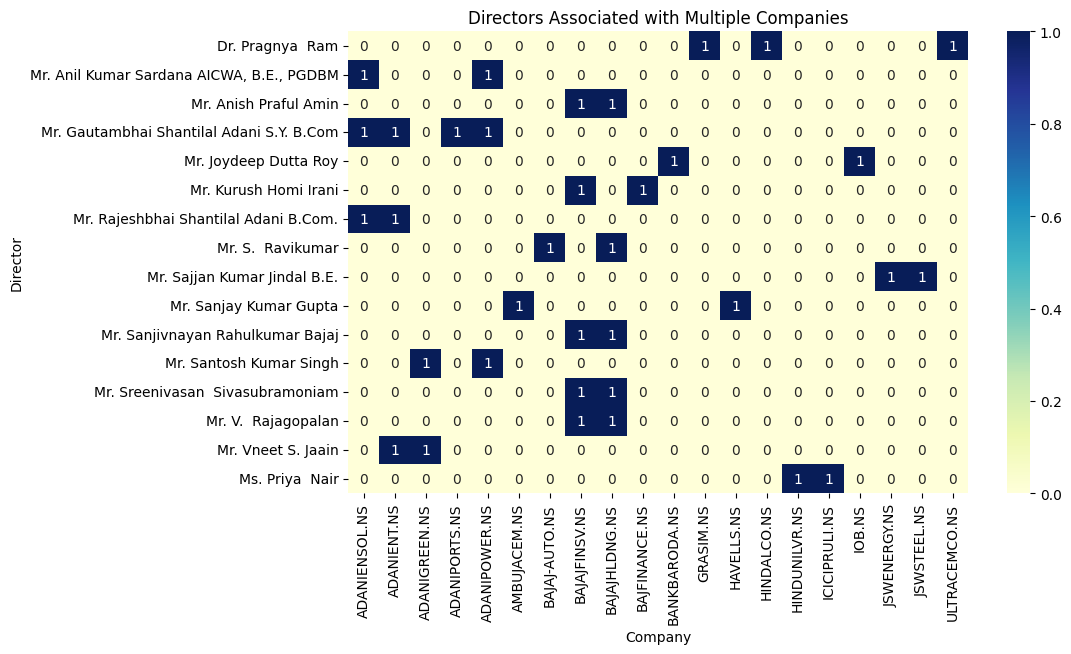

In [ ]:
portfolio = Portfolio(asset_list=NSE_all_scripts[:100], portfolio_name="My Portfolio")

Energy


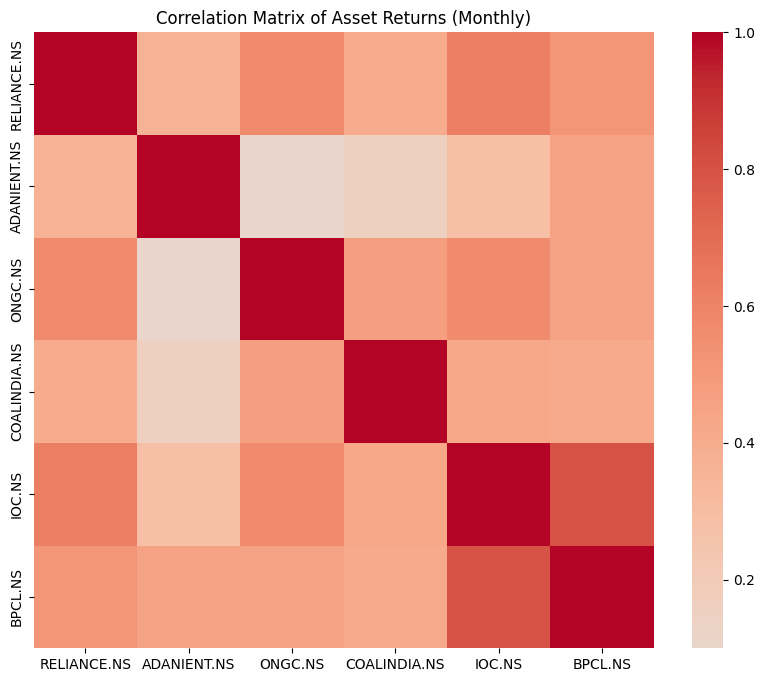

,feature_1,feature_2,corr_coef
0,ADANIENT.NS,ONGC.NS,0.099640
1,ADANIENT.NS,COALINDIA.NS,0.159219
2,ADANIENT.NS,IOC.NS,0.289309
3,RELIANCE.NS,ADANIENT.NS,0.367213
4,COALINDIA.NS,RELIANCE.NS,0.404721


Technology


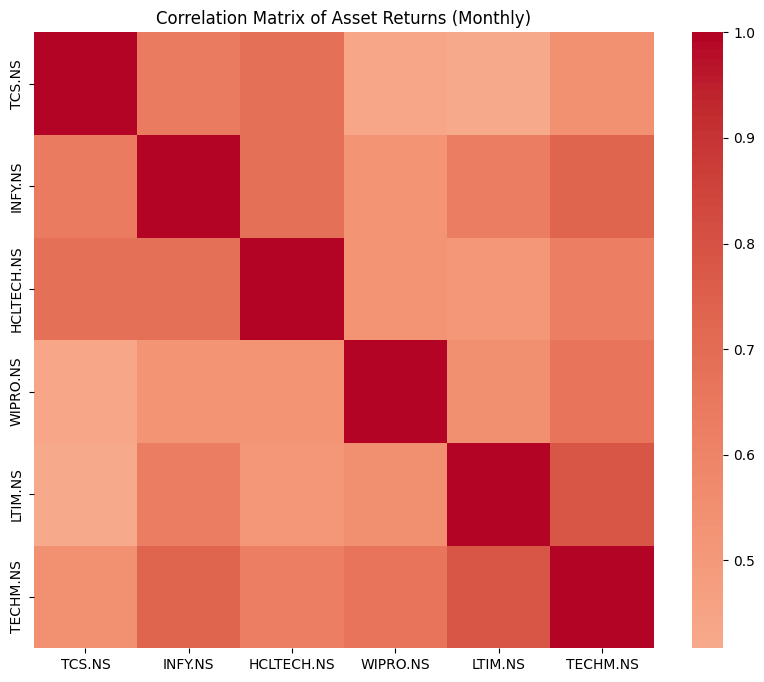

,feature_1,feature_2,corr_coef
0,TCS.NS,LTIM.NS,0.416854
1,TCS.NS,WIPRO.NS,0.435924
2,LTIM.NS,HCLTECH.NS,0.511063
3,WIPRO.NS,HCLTECH.NS,0.526996
4,INFY.NS,WIPRO.NS,0.527444


Financial Services


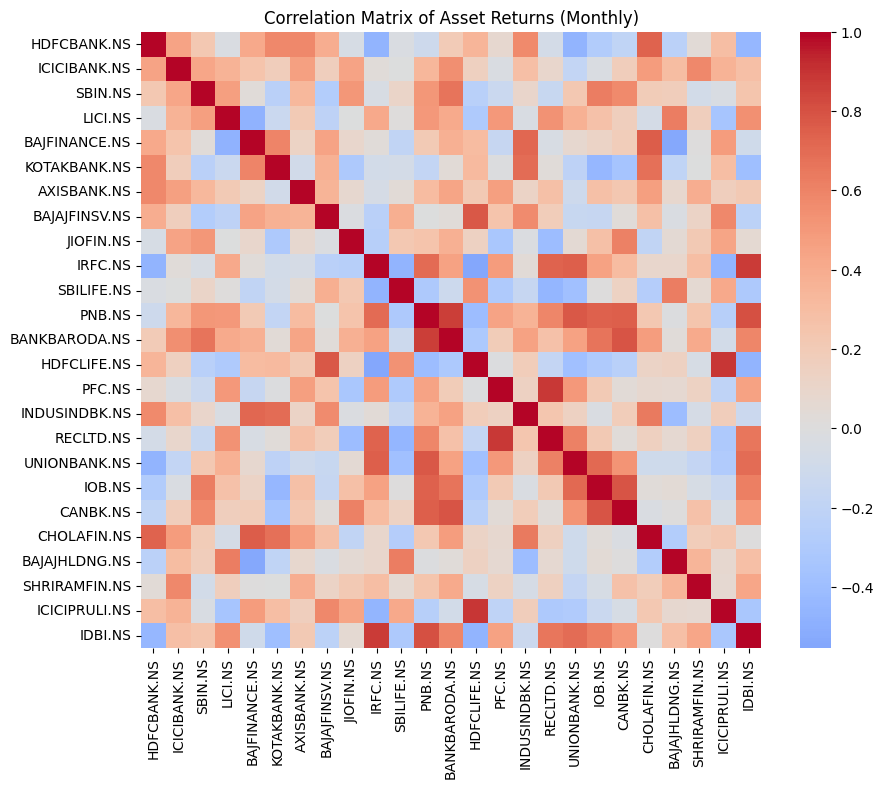

,feature_1,feature_2,corr_coef
0,HDFCLIFE.NS,IRFC.NS,-0.553896
1,BAJAJHLDNG.NS,BAJFINANCE.NS,-0.536259
2,BAJFINANCE.NS,LICI.NS,-0.480262
3,IRFC.NS,SBILIFE.NS,-0.471625
4,HDFCBANK.NS,UNIONBANK.NS,-0.471485


Communication Services


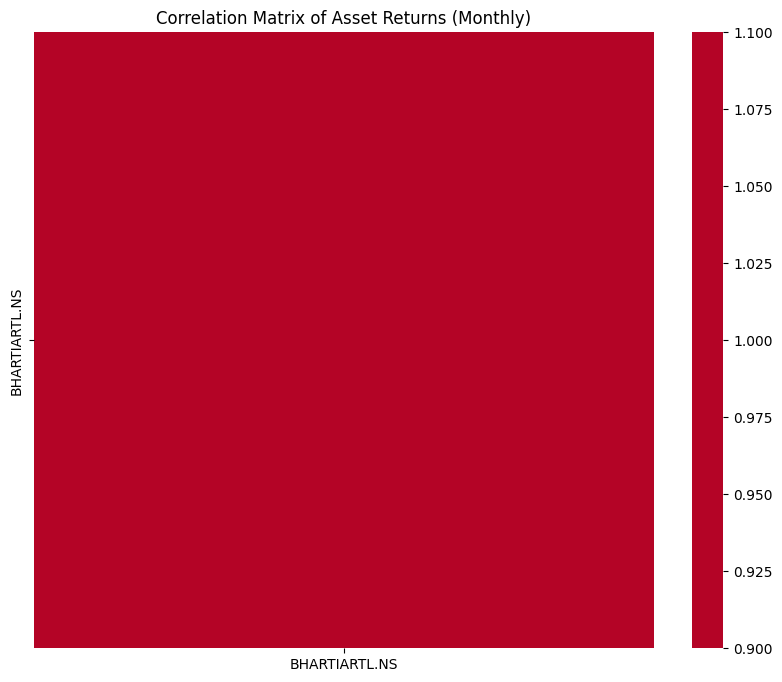

,feature_1,feature_2,corr_coef


Consumer Defensive


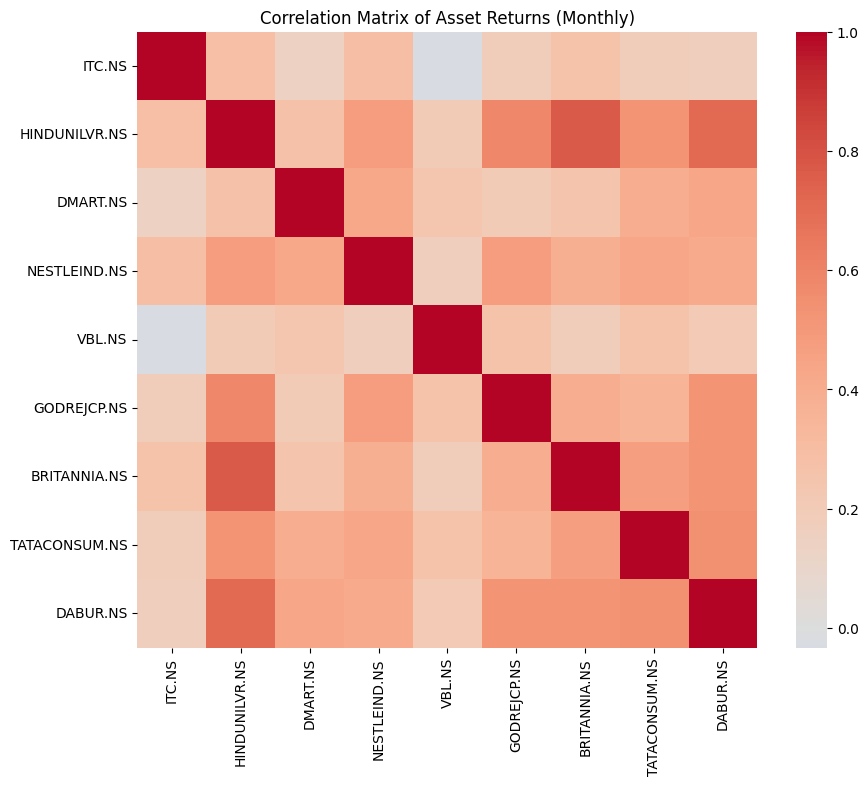

,feature_1,feature_2,corr_coef
0,VBL.NS,ITC.NS,-0.032743
1,ITC.NS,DMART.NS,0.140082
2,VBL.NS,NESTLEIND.NS,0.166590
3,ITC.NS,DABUR.NS,0.168265
4,ITC.NS,GODREJCP.NS,0.177391


Industrials


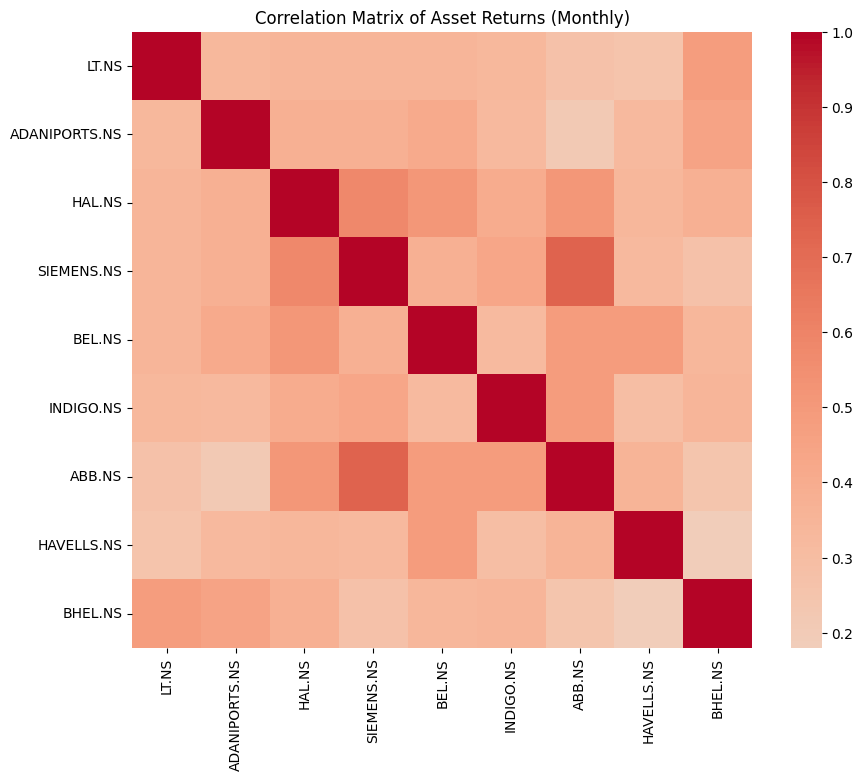

,feature_1,feature_2,corr_coef
0,HAVELLS.NS,BHEL.NS,0.179806
1,ABB.NS,ADANIPORTS.NS,0.212301
2,ABB.NS,BHEL.NS,0.247041
3,LT.NS,HAVELLS.NS,0.258273
4,SIEMENS.NS,BHEL.NS,0.273617


Consumer Cyclical


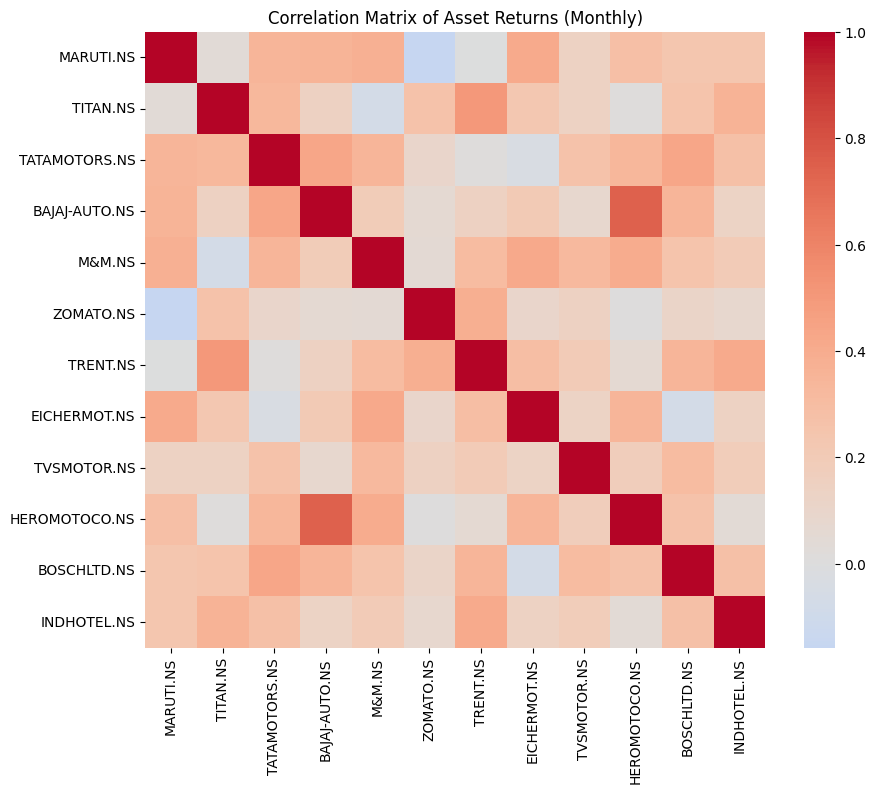

,feature_1,feature_2,corr_coef
0,MARUTI.NS,ZOMATO.NS,-0.157871
1,BOSCHLTD.NS,EICHERMOT.NS,-0.075054
2,TITAN.NS,M&M.NS,-0.072652
3,EICHERMOT.NS,TATAMOTORS.NS,-0.035493
4,TRENT.NS,MARUTI.NS,-0.000024


Healthcare


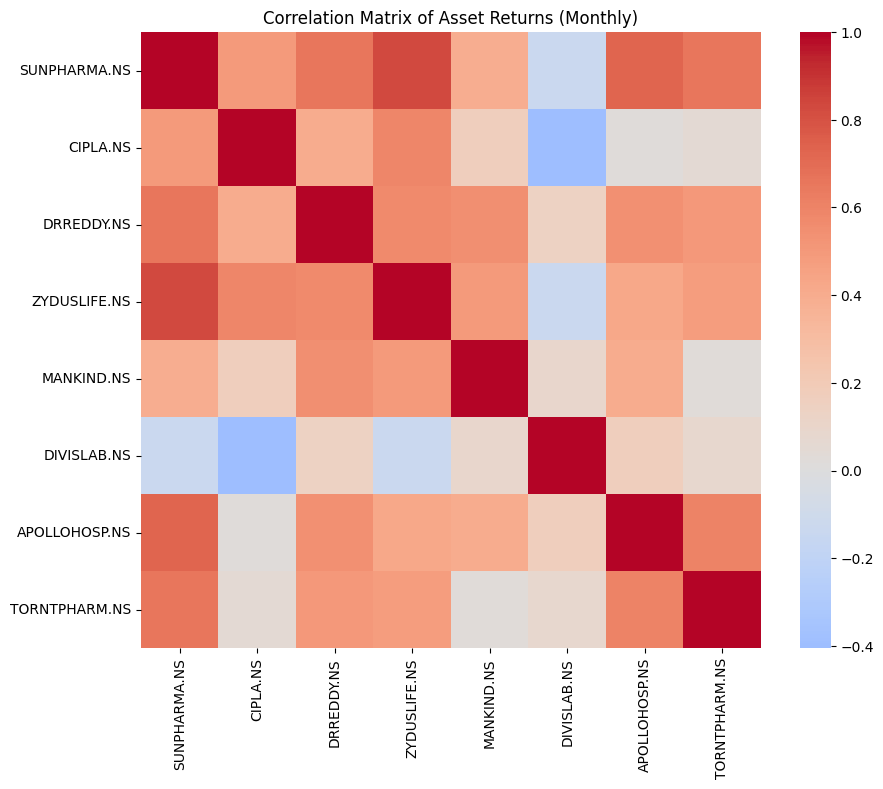

,feature_1,feature_2,corr_coef
0,CIPLA.NS,DIVISLAB.NS,-0.404521
1,DIVISLAB.NS,SUNPHARMA.NS,-0.140222
2,DIVISLAB.NS,ZYDUSLIFE.NS,-0.130232
3,APOLLOHOSP.NS,CIPLA.NS,0.020940
4,MANKIND.NS,TORNTPHARM.NS,0.023596


Utilities


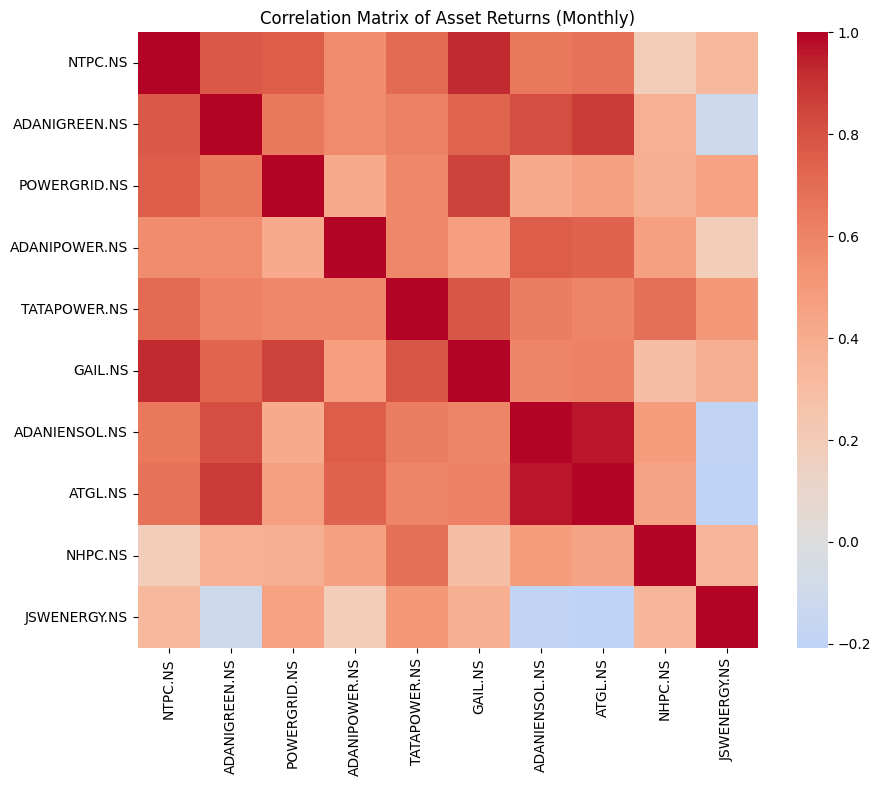

,feature_1,feature_2,corr_coef
0,ATGL.NS,JSWENERGY.NS,-0.208671
1,JSWENERGY.NS,ADANIENSOL.NS,-0.185530
2,ADANIGREEN.NS,JSWENERGY.NS,-0.119775
3,NHPC.NS,NTPC.NS,0.179525
4,JSWENERGY.NS,ADANIPOWER.NS,0.187171


Basic Materials


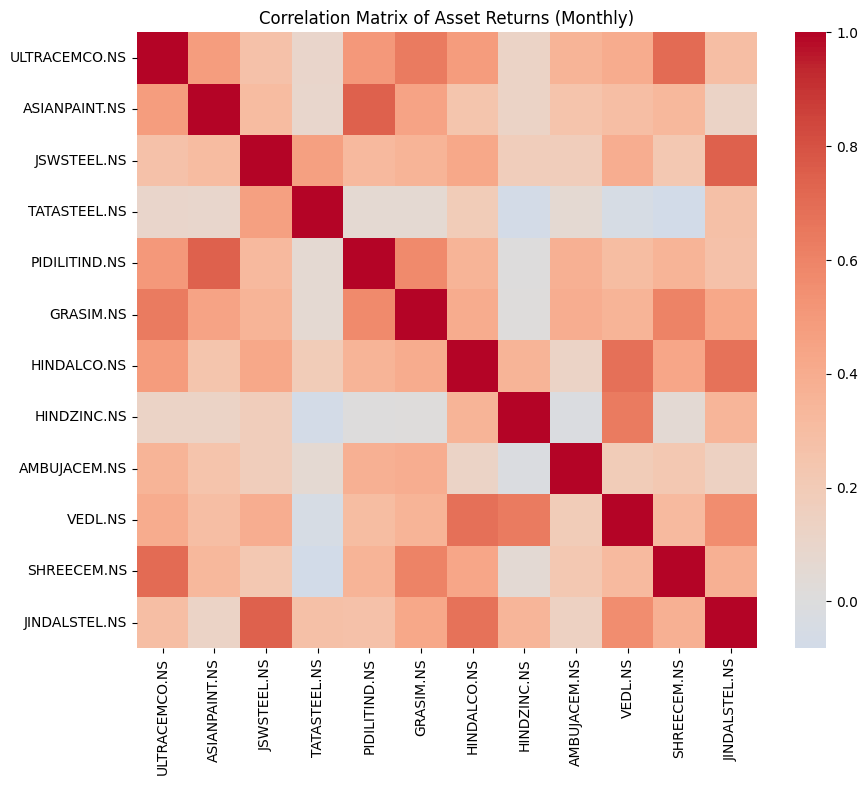

,feature_1,feature_2,corr_coef
0,TATASTEEL.NS,SHREECEM.NS,-0.082271
1,TATASTEEL.NS,HINDZINC.NS,-0.076302
2,VEDL.NS,TATASTEEL.NS,-0.050985
3,AMBUJACEM.NS,HINDZINC.NS,-0.016992
4,HINDZINC.NS,PIDILITIND.NS,0.008988


Real Estate


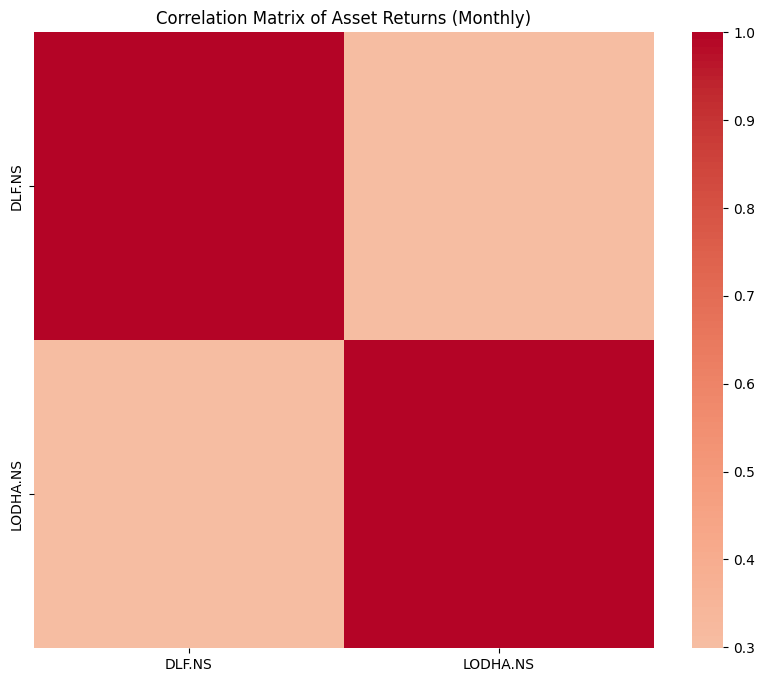

,feature_1,feature_2,corr_coef
0,DLF.NS,LODHA.NS,0.298932


TypeError: 'NoneType' object is not iterable

In [ ]:
portfolio.get_historic_correlations_matrix(by_sector=True)

In [ ]:
portfolio.sectoral_dict

In [ ]:
portfolio.construct_risk_return_plot()

Ticker: RELIANCE.NS
Ticker: TCS.NS
Ticker: HDFCBANK.NS
Ticker: ICICIBANK.NS
Ticker: BHARTIARTL.NS
Ticker: SBIN.NS
Ticker: INFY.NS
Ticker: LICI.NS
Ticker: ITC.NS
Ticker: HINDUNILVR.NS
Ticker: LT.NS
Ticker: BAJFINANCE.NS
Ticker: HCLTECH.NS
Ticker: MARUTI.NS
Ticker: SUNPHARMA.NS
Ticker: ADANIENT.NS
Ticker: KOTAKBANK.NS
Ticker: TITAN.NS
Ticker: ONGC.NS
Ticker: TATAMOTORS.NS
Ticker: NTPC.NS
Ticker: AXISBANK.NS
Ticker: DMART.NS
Ticker: ADANIGREEN.NS
Ticker: ADANIPORTS.NS
Ticker: ULTRACEMCO.NS
Ticker: ASIANPAINT.NS
Ticker: COALINDIA.NS
Ticker: BAJAJFINSV.NS
Ticker: BAJAJ-AUTO.NS
Ticker: POWERGRID.NS
Ticker: NESTLEIND.NS
Ticker: WIPRO.NS
Ticker: M&M.NS
Ticker: IOC.NS
Ticker: JIOFIN.NS
Ticker: HAL.NS
Ticker: DLF.NS
Ticker: ADANIPOWER.NS
Ticker: JSWSTEEL.NS
Ticker: TATASTEEL.NS
Ticker: SIEMENS.NS
Ticker: IRFC.NS
Ticker: VBL.NS
Ticker: ZOMATO.NS
Ticker: PIDILITIND.NS
Ticker: GRASIM.NS
Ticker: SBILIFE.NS
Ticker: BEL.NS
Ticker: LTIM.NS
Ticker: TRENT.NS
Ticker: PNB.NS
Ticker: INDIGO.NS
Ticker: BANKB

# Scenario Modelling

In this next part, we want to define a way to create scenarios to test a portfolio under different circumstances.

In [ ]:
class Scenario():
  '''
  Reads in an excel file in the format provided with a set of assets, with their input dates prices, quantities etc.
  Backtests for the given number of days by sampling returns for each asset over a variable or fixed period as defined.
  Given a target duration for the portfolio, returns a historical probability estimate of expected return assuming only sampled performance.
  '''

TODO:
- Get all ticker history and store the dictionary in a pickle format so that this part of code is not rerun multiple times. Every time the code is being rerun only scrape/ make API call for most recent data.

- Plot a graph of portfolio by industry exposure.
- For each stock plot anomaly based on industry.